In [ ]:
import numpy as np 
import math
from scipy.stats import bernoulli
from scipy.stats import beta
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
import matplotlib as mpl 
mpl.rcParams['font.size'] = 14

In [ ]:
def wealth_process(seq, alpha=0.05, extend=True, stop=False): 
    # Construct wealth process from sequence X using ONS 
    
    wealth = 1
    wealth_hist = [1] 
    const = 2 / (2 - np.log(3))
    lambd = 0 
    zt2 = 0 
    for t in range(1,len(seq)): 
                
        St = 1 - lambd*seq[t]
        wealth = wealth * St 
        wealth_hist.append(wealth)
        if wealth > 1/alpha: 
            #print(f"Reject at time {t}")
            break 
        
        # Update lambda via ONS  
        z = seq[t] / (1 - lambd*seq[t])
        zt2 += z**2
        lambd = max(min(lambd - const*z/(1 + zt2), 1/2), -1/2)
        
    if extend: 
        if len(wealth_hist) < len(seq): 
            buffer = [wealth]*(len(seq)-len(wealth_hist))
            wealth_hist.extend(buffer)
            assert len(wealth_hist) == len(seq), print(len(seq), len(wealth_hist))

        
    return wealth_hist
           

In [ ]:
def plot_wealth(arr, label, c): 
    
    mean = np.mean(arr, axis=0)   
    std = np.std(arr, axis=0)
    plt.plot(range(size), mean, label=label, c=c)
    plt.fill_between(range(len(mean)), mean+std, mean-std, alpha=0.1, color=c)
    


In [ ]:
size = 300
iters = 100 


huge_gap = []
big_gap = []
med_gap = []
no_gap = []

for _ in range(iters): 
    
    
    X1 = bernoulli.rvs(0.7, size=size)
    X2 = bernoulli.rvs(0.4, size=size)
    X3 = bernoulli.rvs(0.4, size=size)
    X4 = bernoulli.rvs(0.55, size=size)
    X5 = bernoulli.rvs(0.9, size=size)

    wealth = wealth_process(X1 - X2, alpha=0.01)
    big_gap.append(wealth)
    
    wealth = wealth_process(X3 - X4, alpha=0.01)
    med_gap.append(wealth)
    
    wealth = wealth_process(X2 - X3, alpha=0.01)
    no_gap.append(wealth)
    
    wealth = wealth_process(X3 - X5, alpha=0.01)
    huge_gap.append(wealth)

plot_wealth(huge_gap, label='$\Delta=0.5$', c='purple')    
plot_wealth(big_gap, label='$\Delta=0.3$', c='navy')
plot_wealth(med_gap, label='$\Delta=0.1$', c='green')
plot_wealth(no_gap, label='$\Delta=0$', c='tab:olive')
    
plt.hlines(1/0.01, 0, size, ls='--', color='k', label='$1/\\alpha$')

plt.title('Growth of wealth process', fontsize=14)
plt.ylim(-10, 150)
plt.ylabel('Wealth')
plt.xlabel('Time')
plt.legend(bbox_to_anchor=(0.97,-0.2), ncol=3)

plt.savefig('plots/wealth_proc.png', dpi=300, bbox_inches='tight')

# Distribution shift 

In [279]:
def sigmoid(x): 
    return 0.5 / (1 + np.exp(-6*x))

def gen_shifted_rvs(mean1, mean2, shift): 

    X1 = bernoulli.rvs(mean1[0], size=len(mean1))
    X2 = list(bernoulli.rvs(mean1[0], size=shift))
    for t in range(shift, len(mean1)): 
        X2.append(bernoulli.rvs(p=mean2[t], size=1)[0])
        
    return X1, np.array(X2)

def gen_bernoullis(mean1, mean2): 
    
    assert len(mean1) == len(mean2)

    X1 = []
    X2 = []
    for t in range(len(mean1)):
        X1.append(bernoulli.rvs(p=mean1[t], size=1)[0])
        X2.append(bernoulli.rvs(p=mean2[t], size=1)[0])
        
    return np.array(X1), np.array(X2)



In [ ]:
size = 400 
shift = 100 
mean1 = [0.3] * size # constant 
mean2 = [0.3] * shift 


for t in range(shift, size): 
    x = t - (size+shift)/2
    x /= (size - shift)/2
    mean2.append(0.3 + sigmoid(x))
    
trials = 100 

results = []
for _ in range(trials): 

    X1, X2 = gen_shifted_rvs(mean1, mean2, shift=shift)
    wealth = wealth_process(X1 - X2, alpha=0.01)
    results.append(wealth)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    

mean = np.mean(results, axis=0)
std = np.std(results, axis=0)
ax2.plot(range(len(wealth)), mean, label='$\mathcal{K}_t$')
ax2.fill_between(range(len(wealth)), mean+std, mean-std, alpha=0.1)
ax2.axhline(1/0.01, ls='--', color='k', label='$1/\\alpha$')
ax2.set_ylabel('Wealth')
ax2.set_xlabel('Time')
ax2.legend(loc='upper left')
    
ax1.plot(range(size), mean1, lw=2, label='$\mu_0(t)$', c='gray')
ax1.plot(range(size), mean2, lw=2, label='$\mu_1(t)$', c='navy')
ax1.set_ylabel('$\mathbb{E}[X|\\xi_b]$')

ax1.set_ylim(0.1,0.9)
ax1.legend()

plt.savefig('plots/dist_shift1.png', dpi=300, bbox_inches='tight')


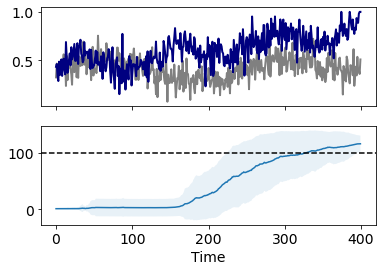

In [293]:
shift = 100 
size = 400


# mean1 = []
# mean2 = [] 
# for t in range(size): 
#     mean1.append(np.sin(t/20)/10 + 0.4 + t/1000)
#     mean2.append(np.sin(t/40)/10 + 0.4)
    
# # add noise 
# mean1 = np.array(mean1) + np.random.normal(0, scale=0.1, size=size)
# mean1 = np.minimum(mean1, [1]*size)
# mean2 = np.array(mean2) + np.random.normal(0, scale=0.1, size=size)
# mean2 = np.maximum(mean2, [0]*size)

    
# trials = 100 
# results = []
# for _ in range(trials): 

#     X1, X2 = gen_bernoullis(mean1, mean2)
#     wealth = wealth_process(X1 - X2, alpha=0.01)
#     results.append(wealth)
    

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)    
ax1.plot(range(size), mean2, lw=2, label='$\mu_0(t)$', c='gray')
ax1.plot(range(size), mean1, lw=2, label='$\mu_1(t)$', c='navy')
# ax1.set_ylabel('$\mathbb{E}[X|\\xi_b]$')
#ax1.legend(ncol=2, loc='upper left')


mean = np.mean(results, axis=0)
std = np.std(results, axis=0)
ax2.plot(range(len(wealth)), mean, label='$\mathcal{K}_t$')
ax2.fill_between(range(len(wealth)), mean+std, mean-std, alpha=0.1)
ax2.axhline(1/0.01, ls='--', color='k', label='$1/\\alpha$')
# ax2.set_ylabel('Wealth')
ax2.set_xlabel('Time')
# ax2.legend(loc='upper left')

plt.savefig('plots/dist_shift2.png', dpi=300, bbox_inches='tight')


In [ ]:
# Old 

In [ ]:
deltas = np.linspace(0, 1, 40)

 
times = []
n_iters = 50 
for _ in range(n_iters): 
    ts = []
    for delta in deltas: 
        X1 = bernoulli.rvs(0.5 - delta/2, size=500)
        X2 = bernoulli.rvs(0.5 + delta/2, size=500)
        seq = X1 - X2
        wealth = wealth_process(seq, alpha=0.01)
        ts.append(len(wealth))
    times.append(ts)
    


In [ ]:
avg_times = np.mean(times, axis=0)[3:]
std = np.std(times, axis=0)[3:]

plt.plot(deltas[3:], avg_times, lw=3)
plt.fill_between(deltas[3:], avg_times + std, avg_times - std, alpha=0.2)
plt.title('Time to rejection under alternative', fontsize=14)
plt.xlabel('$\Delta$')
plt.ylabel('Time')
plt.yscale('log')

plt.savefig('plots/time_to_reject.png', dpi=300, bbox_inches='tight')